# **Assignment 1** (Intro to Machine Learning)

## Note:

* The dataset to be used is `attrition.csv`. This dataset reveals whether a particular employee left the company or not.  
* In this dataset, the column named `Attrition` is the target variable and the remaining columns are features. Please note that `Attrition = 1` means the employee left the company, whereas `Attrition = 0` means the opposite of this statement. 
*  This dataset has been loaded in this assignment as shown below. In case, you are not able to load this data, please note that this data is stored separately as well in the assignment folder. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [3]:
data_url = "https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L1/attrition.csv"
attrition_data = pd.read_csv(data_url)

print(attrition_data.shape)

(1028, 34)


<Figure size 432x288 with 0 Axes>

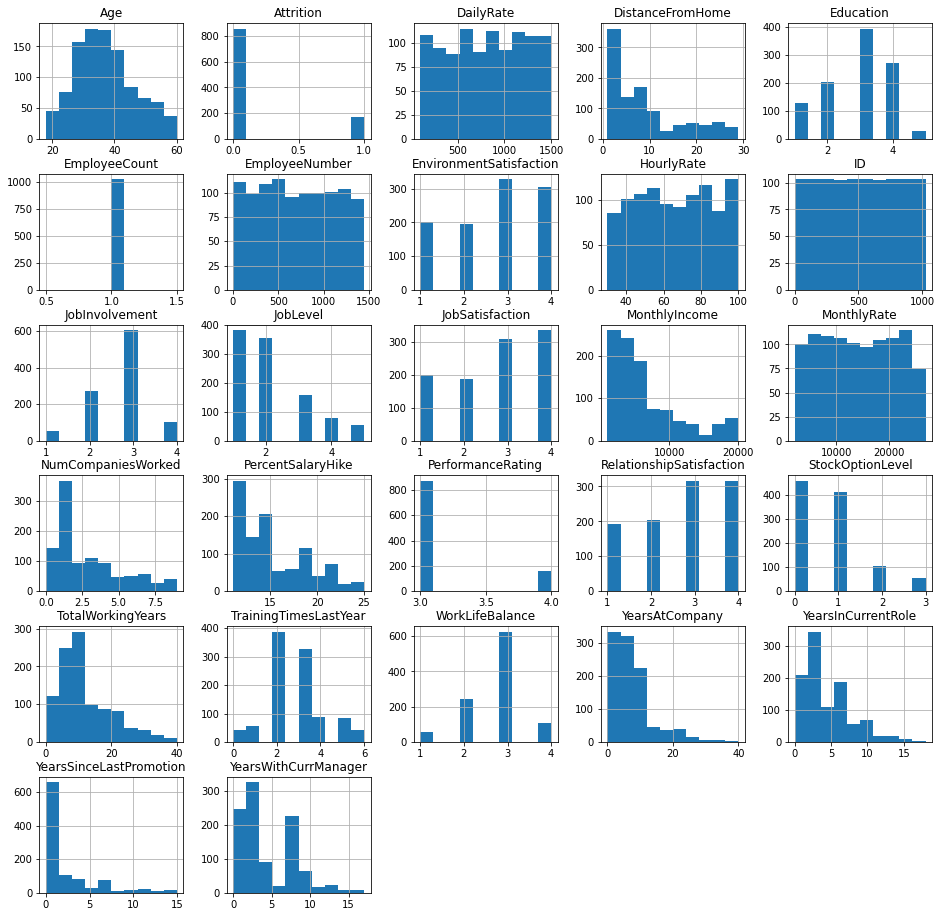

<Figure size 432x288 with 0 Axes>

In [4]:
attrition_data.hist(figsize = (16,16))
plt.figure()

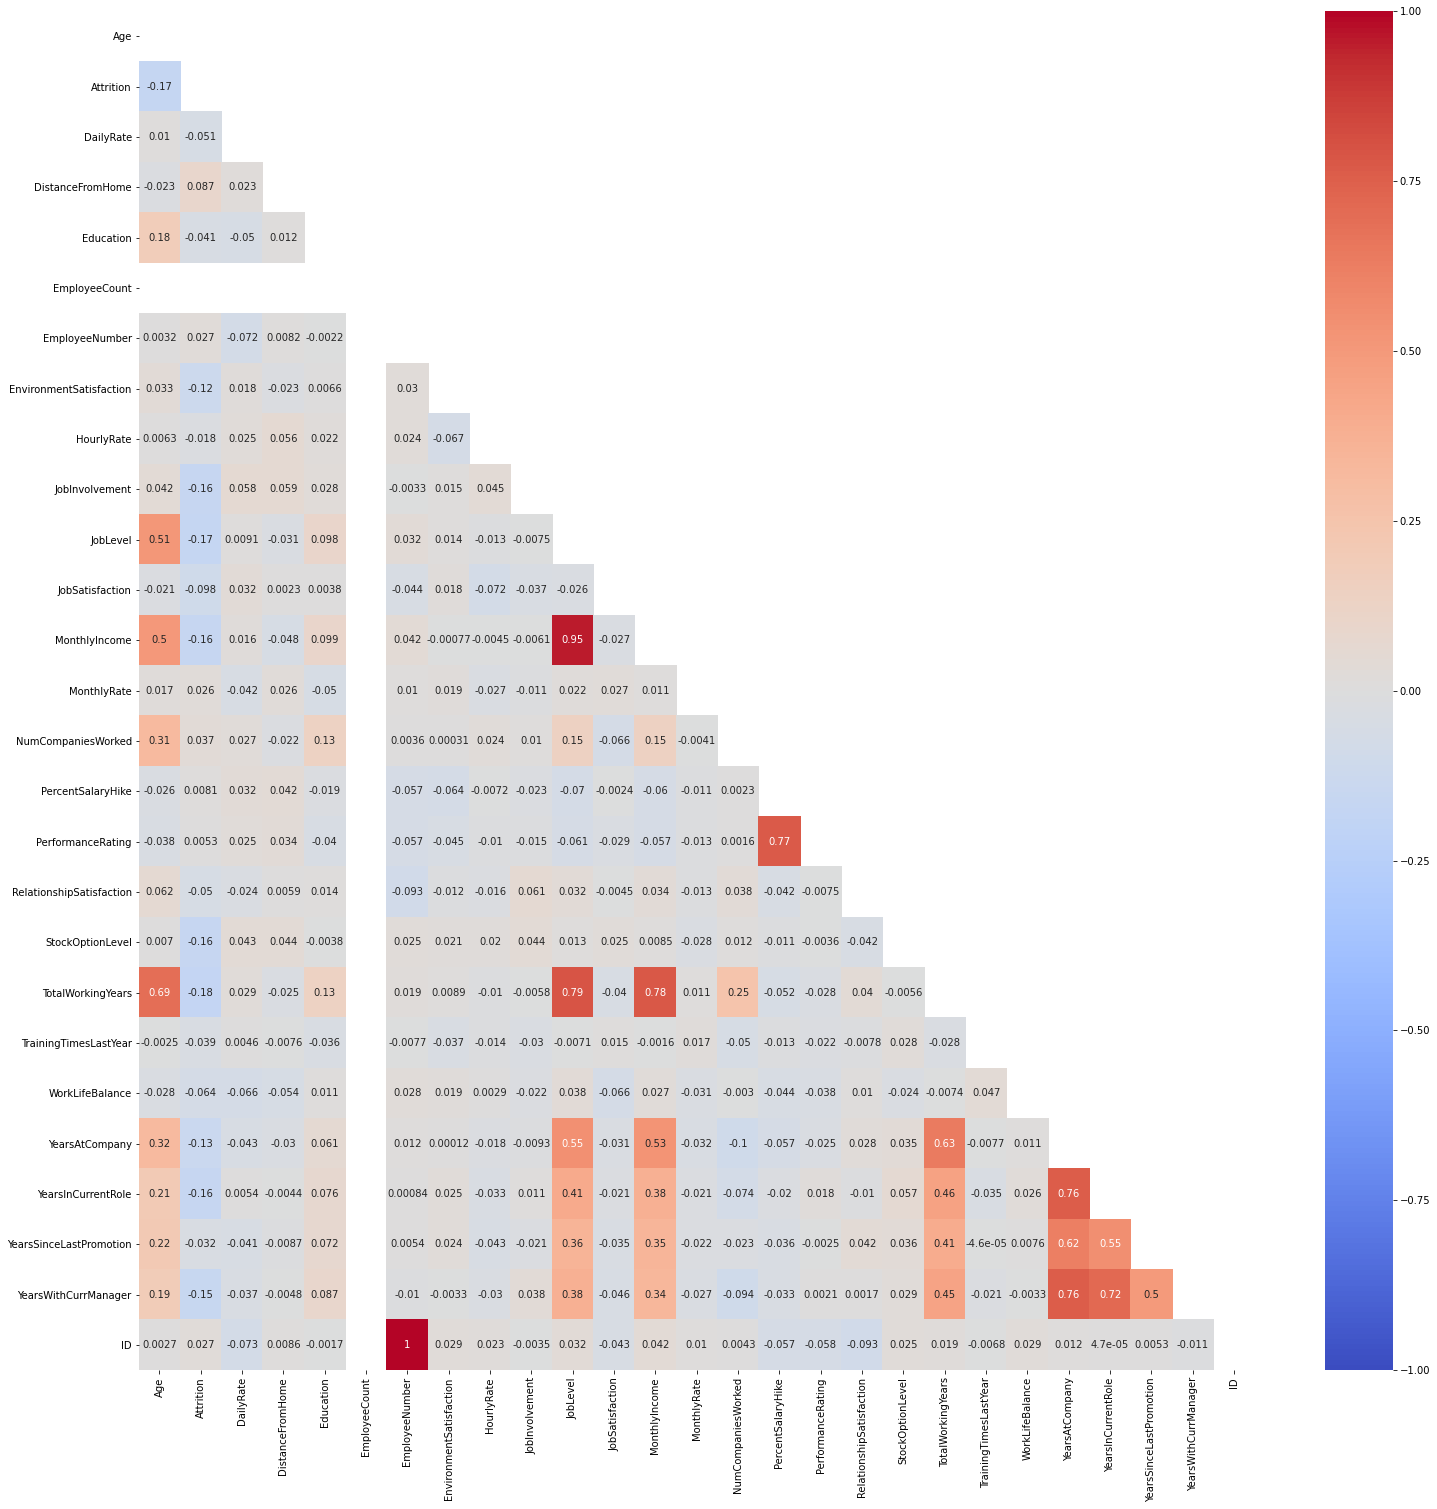

In [5]:
plt.figure(figsize=(25,25))
mask = np.zeros_like(attrition_data.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(attrition_data.corr(), 
            vmin = -1,
            cmap='coolwarm',
            annot=True,
            mask=mask)

plt.show()

In [0]:
# extracting labels for data
y = attrition_data['Attrition']
# dropping columns by observing histograms and heatmap
X = attrition_data.drop(['Attrition', 'ID', 'EmployeeCount', 'EmployeeNumber', 'JobLevel'], axis = 1)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1028 non-null   int64 
 1   BusinessTravel            1028 non-null   object
 2   DailyRate                 1028 non-null   int64 
 3   Department                1028 non-null   object
 4   DistanceFromHome          1028 non-null   int64 
 5   Education                 1028 non-null   int64 
 6   EducationField            1028 non-null   object
 7   EnvironmentSatisfaction   1028 non-null   int64 
 8   Gender                    1028 non-null   object
 9   HourlyRate                1028 non-null   int64 
 10  JobInvolvement            1028 non-null   int64 
 11  JobRole                   1028 non-null   object
 12  JobSatisfaction           1028 non-null   int64 
 13  MaritalStatus             1028 non-null   object
 14  MonthlyIncome           

In [8]:
# label encoding of 'Gender' field because it has two values 'Male' and "Female"
# label encoding of 'OverTime' field because it has two values 'Yes' and 'NO'
label_encoder = LabelEncoder() 

X['Gender'] = label_encoder.fit_transform(X['Gender']) 
X['OverTime'] = label_encoder.fit_transform(X['OverTime']) 

X.head(3)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,94,3,Sales Executive,4,Single,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,61,2,Research Scientist,2,Married,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,92,2,Laboratory Technician,3,Single,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0


In [9]:
# converting categorial columns into numeric using one-hot encoding

non_numeric_col = X.select_dtypes(exclude = np.number).columns
X_new = pd.get_dummies(X, columns = non_numeric_col)
X_new.head(3)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1102,1,2,2,0,94,3,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,1,61,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,1,92,2,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [10]:
X_new.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.00000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,36.999027,806.551556,9.010700,2.873541,2.719844,0.580739,65.451362,2.731518,2.757782,6632.573930,14243.531128,2.697471,0.293774,15.172179,3.152724,2.732490,0.758755,11.417315,2.769455,2.763619,7.100195,4.263619,2.210117,4.141051,0.099222,0.191634,0.709144,0.035019,0.664397,0.300584,0.014591,0.415370,0.115759,0.311284,0.055447,0.087549,0.082685,0.027237,0.178016,0.076848,0.10214,0.057393,0.203307,0.216926,0.055447,0.225681,0.441634,0.332685
std,9.444297,407.043735,8.078418,1.032840,1.089614,0.493678,20.274229,0.703240,1.105306,4855.747841,7048.768076,2.527534,0.455712,3.647641,0.359896,1.088774,0.836236,8.015441,1.302518,0.703005,6.316289,3.630387,3.288559,3.608460,0.299105,0.393778,0.454378,0.183918,0.472431,0.458735,0.119969,0.493026,0.320091,0.463244,0.228963,0.282775,0.275539,0.162854,0.382712,0.266480,0.30298,0.232705,0.402655,0.412352,0.228963,0.418233,0.496823,0.471404
min,18.000000,102.000000,1.000000,1.000000,1.000000,0.000000,30.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.750000,2.000000,2.000000,2.000000,0.000000,48.000000,2.000000,2.000000,2886.000000,8259.750000,1.000000,0.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,813.000000,7.000000,3.000000,3.000000,1.000000,65.000000,3.000000,3.000000,4907.500000,14074.500000,2.000000,0.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43.000000,1157.250000,13.000000,4.000000,4.000000,1.000000,83.000000,3.000000,4.000000,8729.500000,20342.250000,4.000000,1.000000,18.000000,3.000000,4.000000,1.000000

In [11]:
# Normalizing columns using min-max scaler
min_max_scaler = MinMaxScaler(feature_range = (0, 1))
X_scale = pd.DataFrame(min_max_scaler.fit_transform(X_new), columns = X_new.columns)
X_scale.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.547619,0.715820,0.000000,0.25,0.333333,0.0,0.914286,0.666667,1.000000,0.262454,0.698053,0.888889,1.0,0.000000,0.0,0.000000,0.000000,0.200,0.0,0.000000,0.15,0.222222,0.000000,0.294118,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.738095,0.126700,0.250000,0.00,0.666667,1.0,0.442857,0.333333,0.333333,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.5,0.666667,0.25,0.388889,0.066667,0.411765,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.452381,0.909807,0.035714,0.25,1.000000,1.0,0.885714,0.333333,0.666667,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.5,0.666667,0.00,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.357143,0.923407,0.071429,0.75,1.000000,0.0,0.371429,0.666667,0.666667,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.5,0.666667,0.20,0.388889,0.200000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.214286,0.350036,0.035714,0.00,0.000000,1.0,0.142857,0.666667,0.333333,0.129489,0.583738,1.000000,0.0,0.071429,0.0,1.000000,0.333333,0.150,0.5,0.666667,0.05,0.111111,0.133333,0.117647,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# spliting data into train(80%) and test(20%)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size = 0.2, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(822, 48)
(206, 48)


## **XGBClassifier**

In [0]:
# Defining the classifier 
estimator = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = 42
)

In [0]:
# Defining the parameters to be tuned 
parameters = {
    'max_depth': range (1, 5, 1),
    'n_estimators': range(100, 200, 20),
    'learning_rate': [0.1, 0.2, 0.3, 0.05]
}

In [0]:
# Instantiating the grid search 
grid_search = GridSearchCV(
    estimator = estimator,
    param_grid = parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose = True
)

In [16]:
# Fitting the grid search 
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   27.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   58.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 800 out of 800 | elapsed:  1.8min finished


({'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 140},
 0.8113878661832625)

In [17]:
# Printing the arguments of the classifier 
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [18]:
xgb_clf = xgb.XGBClassifier(learning_rate =  0.3, max_depth = 1, n_estimators = 140)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
# Applying classifier on train (seen) set
predictions = xgb_clf.predict(X_train)
# accuracy score
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')

90.63 %


In [20]:
# Applying classifier on test (unseen) set
predictions = xgb_clf.predict(X_test)
# accuracy score
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')

86.89 %


In [21]:
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))
# plot roc auc

[[170   2]
 [ 25   9]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       172
           1       0.82      0.26      0.40        34

    accuracy                           0.87       206
   macro avg       0.84      0.63      0.66       206
weighted avg       0.86      0.87      0.84       206



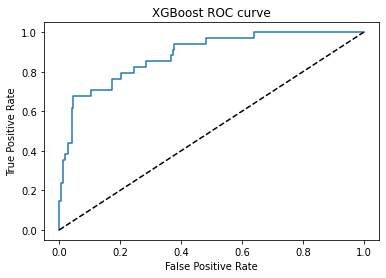

In [22]:
probs = xgb_clf.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve')
# show the plot
plt.show()

## **SVM Classifier**

In [0]:
from sklearn import svm

In [0]:
# Defining the classifier 
estimator = svm.SVC(gamma = 'auto')

In [0]:
# Defining the parameters to be tuned 
parameters = {
    'kernel' : ['linear', 'poly', 'rbf'],
    'C': range (1, 5, 1),
    'degree': [1, 2, 3]
}

In [0]:
# Instantiating the grid search 
grid_search = GridSearchCV(
    estimator = estimator,
    param_grid = parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose = True
)

In [27]:
# Fitting the grid search 
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 360 out of 360 | elapsed:    8.4s finished


({'C': 2, 'degree': 1, 'kernel': 'linear'}, 0.8348323777671605)

In [28]:
# Printing the arguments of the classifier 
grid_search.best_estimator_

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
svm_clf = svm.SVC(kernel = 'linear', degree = 1, C = 2, gamma = 'auto', probability = True)
svm_clf.fit(X_train, y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
# Applying classifier on train (seen) set
predictions = svm_clf.predict(X_train)
# accuracy score
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')

89.17 %


In [31]:
# Applying classifier on test (unseen) set
predictions = svm_clf.predict(X_test)
# accuracy score
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')

87.86 %


In [32]:
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))

[[165   7]
 [ 18  16]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       172
           1       0.70      0.47      0.56        34

    accuracy                           0.88       206
   macro avg       0.80      0.71      0.75       206
weighted avg       0.87      0.88      0.87       206



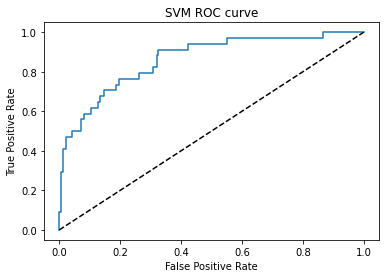

In [33]:
probs = svm_clf.predict_proba(X_test) 
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC curve')
plt.show()

## **RandomForestClassifier**

In [0]:
# Defining the classifier 
estimator = RandomForestClassifier()

In [0]:
# Defining the parameters to be tuned 
parameters = {
    'max_depth': range (2, 6, 1),
    'n_estimators': range(40, 200, 20),
    'criterion': ['gini', 'entropy']
}

In [0]:
# Instantiating the grid search 
grid_search = GridSearchCV(
    estimator = estimator,
    param_grid = parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose = True
)

In [37]:
# Fitting the grid search 
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   29.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 640 out of 640 | elapsed:  1.9min finished


({'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 140},
 0.7837642749407456)

In [38]:
# Printing the arguments of the classifier 
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
rf_clf = RandomForestClassifier(max_depth = 5, criterion = 'gini', n_estimators = 120, random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
# Applying classifier on train (seen) set
predictions = rf_clf.predict(X_train)
# accuracy score
accuracy = accuracy_score(y_train, predictions)
print(np.round(accuracy*100, 2), '%')

85.89 %


In [41]:
# Applying classifier on test (unseen) set
predictions = rf_clf.predict(X_test)
# accuracy score
accuracy = accuracy_score(y_test, predictions)
print(np.round(accuracy*100, 2), '%')

84.47 %


In [42]:
print(confusion_matrix(y_test, predictions))
print("="*60)
print(classification_report(y_test, predictions))
# plot roc auc

[[171   1]
 [ 31   3]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       172
           1       0.75      0.09      0.16        34

    accuracy                           0.84       206
   macro avg       0.80      0.54      0.54       206
weighted avg       0.83      0.84      0.79       206



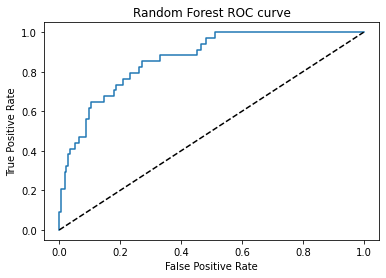

In [43]:
probs = rf_clf.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
# show the plot
plt.show()

## **Result**
Accuracy of SVM clssifier(88%) is better than XGBClassifier(87%) and SVM took less training time.


In [44]:
print("Accuracy of SVM clssifier(88%) is better than XGBClassifier(87%) and SVM took less training time.")

Accuracy of SVM clssifier(88%) is better than XGBClassifier(87%) and SVM took less training time.


## Instructions:

* You are required to use a classifier, which can predict the `Attrition` for the employees. 
* Before implementing any model, you will have to apply suitable encoding to the features and implement exploratory data analysis to know your data better. 
* You can either define your own custom-made classifer or select classifier(s) available in the `scikit-learn`.
* You are supposed to implement a minimum of three classifiers (e.g.  `RandomForestClassifier`, `XGBClassifier`, `DecisionTreeClassifier`, `KNeighborsClassifier`, etc.) and evaluate which one is giving the best peformance. 
* For each of the classifier,  report the accuracy, precision, recall, roc curve, etc. 

## Resources:

* You might want to refer to the [lecture notebook](https://github.com/shala2020/shala2020.github.io/tree/master/Lecture_Materials/Google_Colab_Notebooks/MachineLearning/L1) for revising the concepts.
* You can also refer to the pre-work material for the first lecture on ML.  